In [1]:
import pandas as pd
import numpy as np
import gpflow
import matplotlib.pyplot as plt
import pickle

import utils as u
from models import Matern12_Model, Poisson_Model_T, SafeMatern32_Model, ST_Model, All_Matern_Model, Poisson_Model
import seaborn as sns
%matplotlib inline


sns.set()
#plt.rcParams['figure.figsize'] = (8, 6)
#plt.rcParams['figure.dpi'] = 100


%load_ext autoreload
%autoreload 2

/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
data = pd.read_csv('../data/gp_cut_weekly_microgrid_parkslope.csv')
data['DATETIME'] = pd.to_datetime(data['DATETIME'])
data.DATE_IND = data.DATE_IND / 100
data.x_point = data.x_point / 100
data.y_point = data.y_point / 100

mean_e = data.groupby('DATETIME')['COUNT'].sum().loc['2015-01-01':'2015-12-31'].mean()

e_s = ((mean_e)*4 / data.GRID_SQUARE.max()) # 201 mean weekly crashes in park slope, divide by # squares
print(e_s)

0.487551096247


In [3]:
search_periods = [[4,12]]

Beginning run [4, 12] : 
Training ends on: 2017-04-30 00:00:00
testing ends on: 2017-07-23 00:00:00
using the safe Matern!
using the safe Matern!
Initial neg. log-likelihood: -3851.52010432
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 477.046187
  Number of iterations: 254
  Number of functions evaluations: 290
using the safe Matern!
using the safe Matern!
using the safe Matern!
using the safe Matern!
added gp pred and error to test
gp_sq_error    0.194444
0              0.977456
dtype: float64


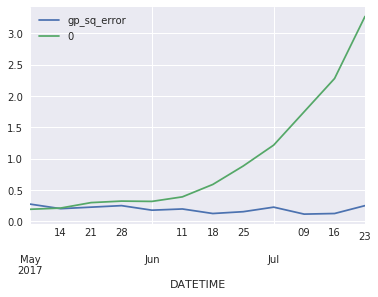

In [5]:
for i, s in enumerate(search_periods):
    
    print('Beginning run {} : '.format(str(s)))
    #print('{} periods for training \n').format(s[0])
    #print('{} periods for testing \n').format(s[1])

    data_dict = u.preprocess(data, start_date= '2017/4/02', training_end_date= s[0], \
                                                           testing_end_date=s[1])

    m = Poisson_Model_T(data_dict['X_train'],data_dict['y_train'],use_priors=False, e_s= e_s, period = 1)
    m.compile()
    opt = gpflow.train.ScipyOptimizer()
    print('Initial neg. log-likelihood: {}'.format(str(m.compute_log_likelihood())))
    opt.minimize(m, maxiter = 1000)
    
    u.pred_GP(m,data_dict)
    
    test = data_dict['test']

    gp = test.groupby('DATETIME')['gp_sq_error'].mean() #/ test.GRID_SQUARE.max()
    ar = u.run_AR(data_dict)
    summary = pd.concat([gp,ar],axis=1)
    summary.plot()

    print(summary.mean())


In [6]:
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
VGP/kern/safematern32/variance,Parameter,"student-T([ 0.],[ 5.][ 4.])",+ve,True,(),True,2.0545936236436932
VGP/kern/safematern32/lengthscales,Parameter,"student-T([ 0.],[ 5.][ 4.])",+ve,True,(),True,2.1371895864856247
VGP/kern/rbf/variance,Parameter,"student-T([ 0.],[ 5.][ 4.])",+ve,True,(),True,2.027824573954385
VGP/kern/rbf/lengthscales,Parameter,"student-T([ 0.],[ 5.][ 4.])",+ve,True,(),True,2.310586314551574
VGP/kern/rbf/variance,Parameter,"student-T([ 0.],[ 5.][ 4.])",+ve,True,(),True,2.027824573954385
VGP/kern/rbf/lengthscales,Parameter,"student-T([ 0.],[ 5.][ 4.])",+ve,True,(),True,2.310586314551574
VGP/kern/periodic/variance,Parameter,"student-T([ 0.],[ 5.][ 4.])",+ve,True,(),True,1.7458542046986196
VGP/kern/periodic/period,Parameter,None,+ve,True,(),True,0.057298362663374194
VGP/kern/periodic/lengthscales,Parameter,"student-T([ 0.],[ 5.][ 4.])",+ve,True,(),True,3.119996346836708
VGP/kern/safematern32/variance,Parameter,"student-T([ 0.],[ 5.][ 4.])",+ve,True,(),True,2.0545936236436932


using the safe Matern!
using the safe Matern!
using the safe Matern!
using the safe Matern!


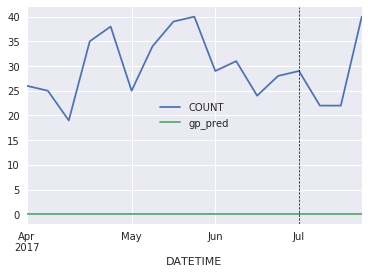

In [7]:
pred_train = m.predict_y(data_dict['X_train'])
pred_test = m.predict_y(data_dict['X_test'])

train = data_dict['train']
train['gp_pred'] = np.round(pred_train[0],0)
train['gp_var'] = pred_train[1]
train['gp_error'] = train.gp_pred - train.COUNT
train['gp_sq_error'] = np.square(train.gp_error)




test = data_dict['test']
test['gp_pred'] = np.round(pred_test[0],0)
test['gp_var'] = pred_test[1]


train['f_pred'] = m.predict_f(data_dict['X_train'])[0]
test['f_pred'] = m.predict_f(data_dict['X_test'])[0]



pred = train.append(test)#[['COUNT','gp_pred']]
pred['exp_f_pred'] = np.exp(pred.f_pred)

pred.groupby('DATETIME')[['COUNT','gp_pred']].sum().plot()
plt.axvline('2017-07-02', linestyle='--', color = 'black', linewidth = 0.7)


In [8]:
pred.groupby('GRID_SQUARE')['exp_f_pred'].mean().to_csv('files/microgrid_square_f_scores.csv')

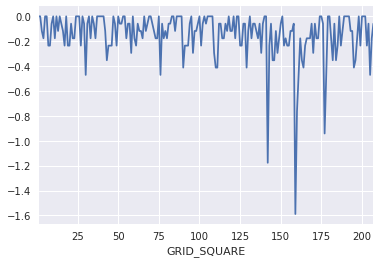

In [9]:
pred.groupby('GRID_SQUARE').mean()['gp_error'].plot()#.sort_values(ascending = False)

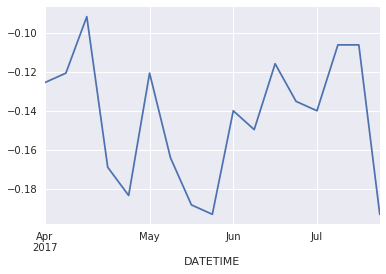

In [10]:
pred.groupby('DATETIME').mean()['gp_error'].plot()#.sort_values(ascending = False)

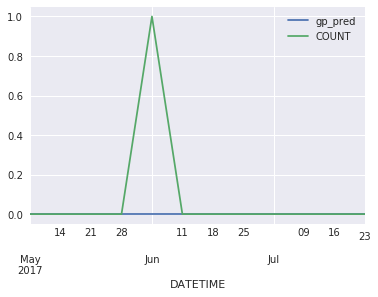

In [11]:
test[test.GRID_SQUARE == 29][['gp_pred','COUNT']].plot()

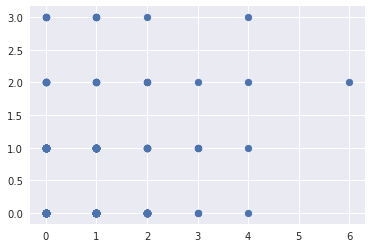

In [28]:
plt.scatter(x = pred.COUNT, y = pred.gp_pred)